# **Neural Network**
This Notebook aims at implementing the handwritten digits (obtained from MNIST Dataset) classification problem
using Pytorch

## 1. Setup and Imports
First, we'll import the required libraries and set up our configuration parameters.

In [204]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms
import torch.nn as nn
from sklearn.model_selection import train_test_split
import random

### 1.1 Configuration and Seed

In [205]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
INPUT_SIZE = 28 * 28  # 784 pixels
BATCH_SIZE = 64
LEARNING_RATE = 0.01
NUM_EPOCHS = 20
SEED = 42

torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)

## 2. Data Preparing

#### 2.1 Loading dataset

In [206]:
def load_mnist():
  train_dataset = datasets.MNIST(root='./data', train=True, download=True)
  test_dataset = datasets.MNIST(root='./data', train=False, download=True)

  full_data = torch.cat((train_dataset.data, test_dataset.data), dim=0)
  full_labels = torch.cat((train_dataset.targets, test_dataset.targets), dim=0)

  # convert from (N, 28, 28) to (N, 784)
  x_flat = full_data.reshape(-1, INPUT_SIZE).numpy()
  y_flat = full_labels.numpy()

  return x_flat, y_flat

#### 2.2 Converting data to tensors

In [207]:
class convert_to_tensors(Dataset):
  def __init__(self, data, labels, reshape_for_cnn=False):
    self.labels = torch.tensor(labels, dtype=torch.long)

    #preprocessing
    data_tensor = torch.tensor(data, dtype=torch.long)
    data_normalized = data_tensor / 255.0 ## 0 -> 1

    if reshape_for_cnn:
      self.data = data_normalized.reshape(-1, 1, 25, 28)
    else:
      self.data = data_normalized

  def __len__(self):
    return len(self.labels)

  def __getitem__(self, idx):
    return self.data[idx], self.labels[idx]

#### 2.3 Splitting data

In [208]:
def split_data(x_flat, y, random_state=42):
  x_train, x_temp, y_train, y_temp = train_test_split(
      x_flat, y,
      test_size = 0.4,
      random_state=random_state,
      stratify=y
  )

  x_val, x_test, y_val, y_test = train_test_split(
      x_temp, y_temp,
      test_size=0.5,
      random_state=random_state,
      stratify=y_temp
  )

  return (x_train, y_train), (x_val, y_val), (x_test, y_test)

#### 2.4 Create Dataloaders

In [209]:
def create_dataloaders(x_train, y_train, x_val, y_val, x_test, y_test, reshape_for_cnn=False):

  train_dataset = convert_to_tensors(x_train, y_train, reshape_for_cnn)
  val_dataset = convert_to_tensors(x_val, y_val, reshape_for_cnn)
  test_dataset = convert_to_tensors(x_test, y_test, reshape_for_cnn)

  train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
  val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
  test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

  return train_dataloader, val_dataloader, test_dataloader


#### 2.5 Getting Data after Preparation

In [210]:
def get_mnist_dataloaders(batch_size=BATCH_SIZE, reshape_for_cnn=False, random_state=42):
  x_flat, y = load_mnist()

  (x_train, y_train), (x_val, y_val), (x_test, y_test) = split_data(x_flat, y, random_state)
  return create_dataloaders(
      x_train, y_train, x_val, y_val, x_test, y_test, reshape_for_cnn
  )

## 3. Neural Network Architecture

#### 3.1 Feed Forward

In [211]:
class feed_forward(nn.Module):
  def __init__(self, layer_sizes):
    super(feed_forward, self).__init__()

    layers = []
    for i in range(len(layer_sizes) - 1):
      layers.append(nn.Linear(layer_sizes[i], layer_sizes[i + 1]))

      if i < len(layer_sizes) - 2:
        layers.append(nn.ReLU())

    self.network = nn.Sequential(*layers)
    self.apply(self._init_weights)

  def _init_weights(self, m):
    # He initialization
    if isinstance(m, nn.Linear):
      nn.init.kaiming_normal_(m.weight, mode='fan_in', nonlinearity = 'relu')
      if m.bias is not None:
        nn.init.constant_(m.bias, 0)
  def forward(self, x):
    return self.network(x)

## 4. Training Infrastructure

#### 4.1 Training loop

In [215]:
def train_epoch(model, dataloader, criterion, optimizer, device):
  model.train()
  running_loss = 0.0

  for images, labels in dataloader:
    images = images.to(device)
    labels = labels.to(device)

    optimizer.zero_grad() # 1. Zero gradients
    outputs = model(images) # 2. Forward pass
    loss = criterion(outputs, labels) # 3. Calculate loss
    loss.backward() # 4. Backward pass
    optimizer.step() # 5. Update weights

    running_loss += loss.item() * images.size(0)

  epoch_loss = running_loss / len(dataloader.dataset)
  return epoch_loss

#### 4.2 Evaluate Model

In [216]:
def evaluate_model(model, dataloader, criterion, device):
  model.eval()
  running_loss = 0.0
  correct = 0
  total = 0

  with torch.no_grad():
    for images, labels in dataloader:
      images = images.to(device)
      labels = labels.to(device)

      # 1. Forward pass
      outputs = model(images)

      # 2. Calculate loss
      loss = criterion(outputs, labels)
      running_loss += loss.item() * images.size(0)

      # 3. Calculate accuracy
      _, predicted = torch.max(outputs.data, 1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()

  epoch_loss = running_loss / len(dataloader.dataset)
  accuracy = 100 * correct / total
  return epoch_loss, accuracy

#### 4.3 Training Model

In [217]:
model_architecture = [INPUT_SIZE, 128, 64, 10]

# Loading data
train_loader, val_loader, test_loader = get_mnist_dataloaders(
    batch_size=BATCH_SIZE, reshape_for_cnn=False
)

# initialize model
model = feed_forward(layer_sizes=model_architecture)

# define loss function
criterion = nn.CrossEntropyLoss()

# define optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE)


# store metrics
train_losses = []
val_losses = []
val_accuracies = []

# start training
for epoch in range(NUM_EPOCHS):
  # run one epoch of training
  train_loss = train_epoch(model, train_loader, criterion, optimizer, DEVICE)

  # evaluate on the validation set
  val_loss, val_accuracy = evaluate_model(model, val_loader, criterion, DEVICE)
  train_losses.append(train_loss)
  val_losses.append(val_loss)
  val_accuracies.append(val_accuracy)

  # trach progress
  print(f"Epoch {epoch+1:2}/{NUM_EPOCHS} | "
              f"Train Loss: {train_loss:.4f} | "
              f"Val Loss: {val_loss:.4f} | "
              f"Val Accuracy: {val_accuracy:.2f}%")

Epoch  1/20 | Train Loss: 0.9684 | Val Loss: 0.4781 | Val Accuracy: 87.15%
Epoch  2/20 | Train Loss: 0.4008 | Val Loss: 0.3636 | Val Accuracy: 89.54%
Epoch  3/20 | Train Loss: 0.3279 | Val Loss: 0.3149 | Val Accuracy: 90.85%
Epoch  4/20 | Train Loss: 0.2909 | Val Loss: 0.2905 | Val Accuracy: 91.60%
Epoch  5/20 | Train Loss: 0.2655 | Val Loss: 0.2717 | Val Accuracy: 92.04%
Epoch  6/20 | Train Loss: 0.2460 | Val Loss: 0.2564 | Val Accuracy: 92.67%
Epoch  7/20 | Train Loss: 0.2295 | Val Loss: 0.2418 | Val Accuracy: 92.96%
Epoch  8/20 | Train Loss: 0.2151 | Val Loss: 0.2272 | Val Accuracy: 93.44%
Epoch  9/20 | Train Loss: 0.2026 | Val Loss: 0.2173 | Val Accuracy: 93.75%
Epoch 10/20 | Train Loss: 0.1918 | Val Loss: 0.2143 | Val Accuracy: 93.81%
Epoch 11/20 | Train Loss: 0.1819 | Val Loss: 0.2021 | Val Accuracy: 94.13%
Epoch 12/20 | Train Loss: 0.1732 | Val Loss: 0.1921 | Val Accuracy: 94.54%
Epoch 13/20 | Train Loss: 0.1652 | Val Loss: 0.1850 | Val Accuracy: 94.69%
Epoch 14/20 | Train Loss:

## 5. Plot training and validation losses and accuracies

In [218]:
def plot_metrics(train_losses, val_losses, val_accuracies):
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(10, 5))
    plt.plot(epochs, train_losses, 'b-o', label='Training Loss')
    plt.plot(epochs, val_losses, 'r-o', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()


    plt.figure(figsize=(10, 5))
    plt.plot(epochs, val_accuracies, 'g-o', label='Validation Accuracy')
    plt.title('Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.grid(True)
    plt.show()

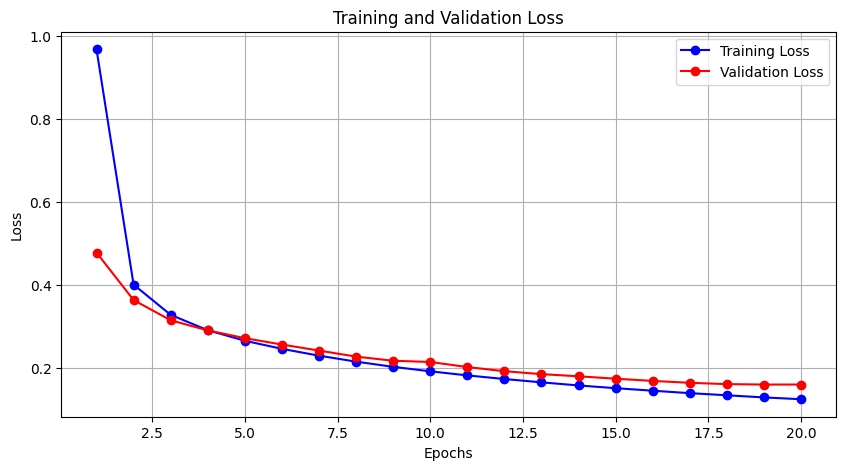

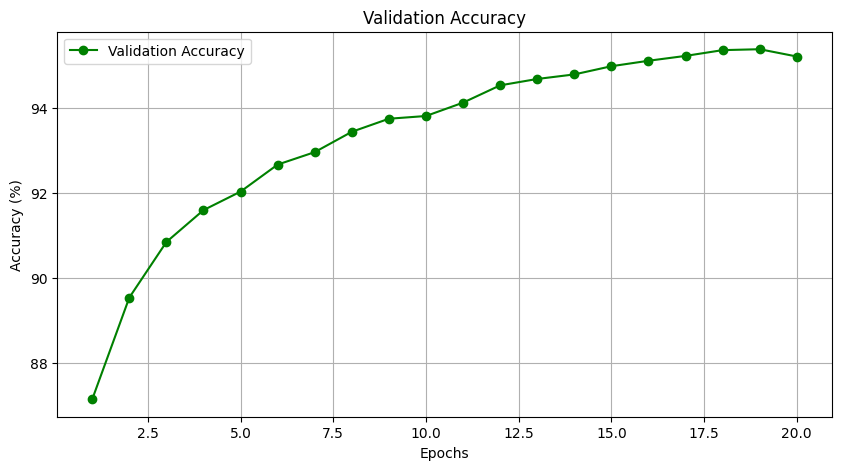

In [219]:
plot_metrics(train_losses, val_losses, val_accuracies)

# 6. Final Test

In [221]:
test_loss, test_accuracy = evaluate_model(model, test_loader, criterion, DEVICE)

In [223]:
print(f"Final Test Results:")
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.2f}%")

Final Test Results:
Test Loss: 0.1543
Test Accuracy: 95.39%
